# Data ophalen

In [1]:
import pyodbc
import pandas as pd

DB = {'servername': 'BOOK-CG1LSBSBIK\\SQLEXPRESS', 'database': 'AdventureWorks2019'}
conn = pyodbc.connect('DRIVER={SQL Server};SERVER='+ DB['servername'] + ';DATABASE=' + DB['database'] + ';Trusted_Connection=yes')

query = """
SELECT 
    YEAR(soh.OrderDate) AS Jaar, 
    MONTH(soh.OrderDate) AS Maand, 
    SUM(sod.LineTotal) AS MaandelijkseVerkoop,
    CASE 
        WHEN MONTH(soh.OrderDate) IN (12, 1, 2) THEN 'Winter'
        WHEN MONTH(soh.OrderDate) IN (3, 4, 5) THEN 'Lente'
        WHEN MONTH(soh.OrderDate) IN (6, 7, 8) THEN 'Zomer'
        ELSE 'Herfst'
    END AS Seizoen
FROM 
    Sales.SalesOrderHeader soh
JOIN 
    Sales.SalesOrderDetail sod ON soh.SalesOrderID = sod.SalesOrderID
GROUP BY 
    YEAR(soh.OrderDate), MONTH(soh.OrderDate)
ORDER BY 
    Jaar, Maand;
"""

df = pd.read_sql(query, conn)

C:\Users\prati\AppData\Local\Temp\ipykernel_16568\2574029714.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
C:\Users\prati\AppData\Local\Temp\ipykernel_16568\2574029714.py:28: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


# Data voorbewerken

In [2]:
df['Jaar'] = pd.to_numeric(df['Jaar'])
df['Maand'] = pd.to_numeric(df['Maand'])
df = pd.get_dummies(df, columns=['Seizoen'], drop_first=True)
df['Seizoen_Herfst'] = 0

# Modeltraining en evaluatie

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

X = df.drop(['MaandelijkseVerkoop'], axis=1)
y = df['MaandelijkseVerkoop']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')

Mean Squared Error: 3343698187875.78
Mean Absolute Error: 1692375.052545517


# Voorspellingen maken

In [4]:
nieuwe_data = {
    'Jaar': [2024],
    'Maand': [7],
    'Seizoen_Lente': [0],  # Aangezien het voor juli is, geen Lente
    'Seizoen_Zomer': [1],  # Aangezien het voor juli is, Zomer
    'Seizoen_Herfst': [0], # Aangezien het voor juli is, geen Herfst
    'Seizoen_Winter': [0]  # Aangezien het voor juli is, geen Winter
}
nieuwe_df = pd.DataFrame(nieuwe_data)
nieuwe_df = nieuwe_df[X_train.columns]

voorspelling = model.predict(nieuwe_df)
print(f'Geschatte verkoop voor Juli 2024: {voorspelling[0]}')

Geschatte verkoop voor Juli 2024: 2234119.0142508615


# Resultaten visualiseren

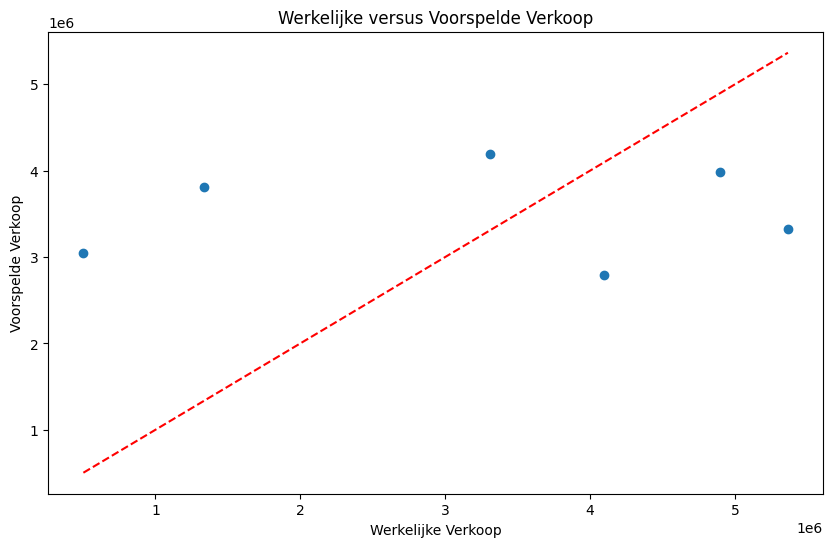

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='red')
plt.xlabel('Werkelijke Verkoop')
plt.ylabel('Voorspelde Verkoop')
plt.title('Werkelijke versus Voorspelde Verkoop')
plt.show()